# Assignment_7

## 1.	Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN, and a vector-to-sequence RNN?

Here are a few RNN applications:

For a sequence-to-sequence RNN: predicting the weather
(or any other time series), machine translation (using an
Encoder–Decoder architecture), video captioning, speech
to text, music generation (or other sequence generation),
identifying the chords of a song

For a sequence-to-vector RNN: classifying music
samples by music genre, analyzing the sentiment of a
book review, predicting what word an aphasic patient is
thinking of based on readings from brain implants,
predicting the probability that a user will want to watch a
movie based on their watch history (this is one of many
possible implementations of collaborative filtering for a
recommender system)

For a vector-to-sequence RNN: image captioning,
creating a music playlist based on an embedding of the
current artist, generating a melody based on a set of
parameters, locating pedestrians in a picture (e.g., a video
frame from a self-driving car’s camera)

## 2.	How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs?

An RNN layer must have three-dimensional inputs: the first
dimension is the batch dimension (its size is the batch size), the
second dimension represents the time (its size is the number of
time steps), and the third dimension holds the inputs at each time
step (its size is the number of input features per time step). For
example, if you want to process a batch containing 5 time series
of 10 time steps each, with 2 values per time step (e.g., the
temperature and the wind speed), the shape will be [5, 10, 2]. The
outputs are also three-dimensional, with the same first two
dimensions, but the last dimension is equal to the number of
neurons. For example, if an RNN layer with 32 neurons processes
the batch we just discussed, the output will have a shape of [5, 10,
32].

## 3.	If you want to build a deep sequence-to-sequence RNN, which RNN layers should have return_sequences=True? What about a sequence-to-vector RNN?

To build a deep sequence-to-sequence RNN using Keras, you must
set return_sequences=True for all RNN layers. To build a
sequence-to-vector RNN, you must set return_sequences=True
for all RNN layers except for the top RNN layer, which must have
return_sequences=False (or do not set this argument at all,
since False is the default).

## 4.	Suppose you have a daily univariate time series, and you want to forecast the next seven days. Which RNN architecture should you use?

If you have a daily univariate time series, and you want to
forecast the next seven days, the simplest RNN architecture you
can use is a stack of RNN layers (all with
return_sequences=True except for the top RNN layer), using
seven neurons in the output RNN layer. You can then train this
model using random windows from the time series (e.g.,
sequences of 30 consecutive days as the inputs, and a vector
containing the values of the next 7 days as the target). This is a
sequence-to-vector RNN. Alternatively, you could set
return_sequences=True for all RNN layers to create a sequenceto-sequence RNN. You can train this model using random
windows from the time series, with sequences of the same length
as the inputs as the targets. Each target sequence should have
seven values per time step (e.g., for time step t, the target should
be a vector containing the values at time steps t + 1 to t + 7).

## 5.	What are the main difficulties when training RNNs? How can you handle them?

The two main difficulties when training RNNs are unstable
gradients (exploding or vanishing) and a very limited short-term
memory. These problems both get worse when dealing with long
sequences. To alleviate the unstable gradients problem, you can
use a smaller learning rate, use a saturating activation function
such as the hyperbolic tangent (which is the default), and possibly
use gradient clipping, Layer Normalization, or dropout at each
time step. To tackle the limited short-term memory problem, you
can use LSTM or GRU layers (this also helps with the unstable
gradients problem).

## 6.	Can you sketch the LSTM cell’s architecture?

An LSTM cell’s architecture looks complicated, but it’s actually
not too hard if you understand the underlying logic. The cell has a
short-term state vector and a long-term state vector. At each time
step, the inputs and the previous short-term state are fed to a
simple RNN cell and three gates: the forget gate decides what to
remove from the long-term state, the input gate decides which
part of the output of the simple RNN cell should be added to the
long-term state, and the output gate decides which part of the
long-term state should be output at this time step (after going
through the tanh activation function). The new short-term state is
equal to the output of the cell. 

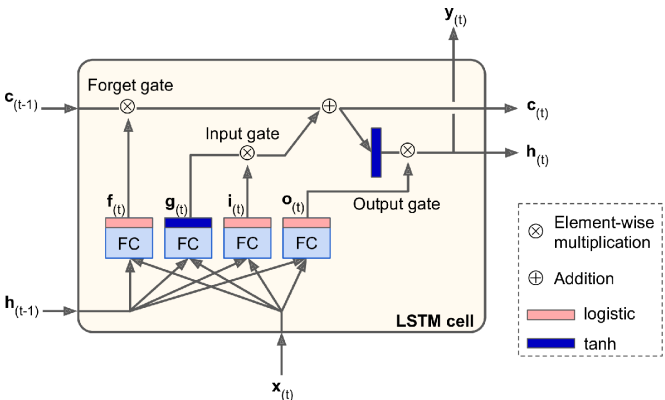

## 7.	Why would you want to use 1D convolutional layers in an RNN?

 An RNN layer is fundamentally sequential: in order to compute
the outputs at time step t, it has to first compute the outputs at all
earlier time steps. This makes it impossible to parallelize. On the
other hand, a 1D convolutional layer lends itself well to
parallelization since it does not hold a state between time steps. In
other words, it has no memory: the output at any time step can be
computed based only on a small window of values from the inputs
without having to know all the past values. Moreover, since a 1D
convolutional layer is not recurrent, it suffers less from unstable
gradients. One or more 1D convolutional layers can be useful in
an RNN to efficiently preprocess the inputs, for example to
reduce their temporal resolution (downsampling) and thereby help
the RNN layers detect long-term patterns. In fact, it is possible to
use only convolutional layers, for example by building a WaveNet
architecture.

## 8.	Which neural network architecture could you use to classify videos?

To classify videos based on their visual content, one possible
architecture could be to take (say) one frame per second, then run
every frame through the same convolutional neural network (e.g.,
a pretrained Xception model, possibly frozen if your dataset is not
large), feed the sequence of outputs from the CNN to a sequenceto-vector RNN, and finally run its output through a softmax layer,
giving you all the class probabilities. For training you would use
cross entropy as the cost function. If you wanted to use the audio
for classification as well, you could use a stack of strided 1D
convolutional layers to reduce the temporal resolution from
thousands of audio frames per second to just one per second (to
match the number of images per second), and concatenate the
output sequence to the inputs of the sequence-to-vector RNN
(along the last dimension).

## 9.	Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065312256/1065301781 [==============================] - 438s 0us/step


In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [4]:
train_files

['C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [5]:
eval_files

['C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\deepikadevi\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [9]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [10]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [11]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [12]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

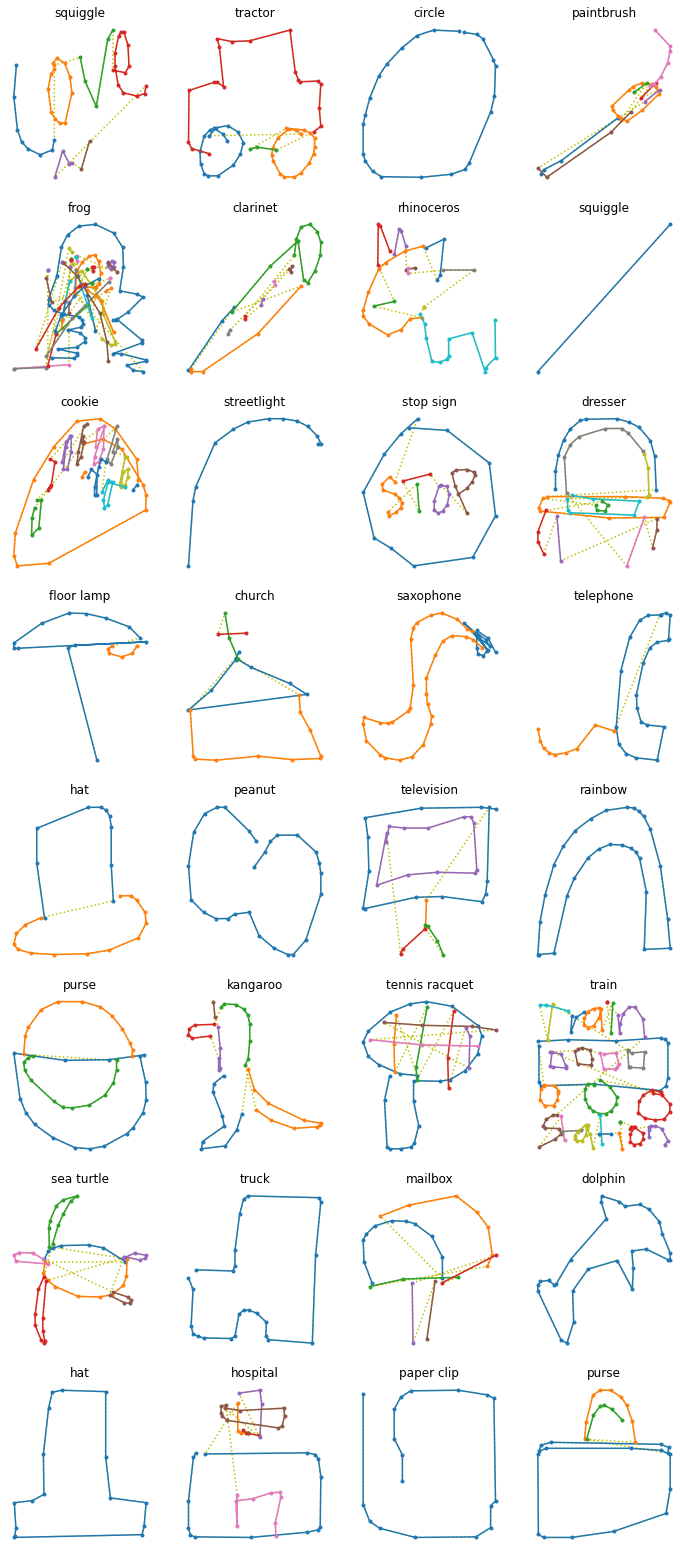

In [13]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

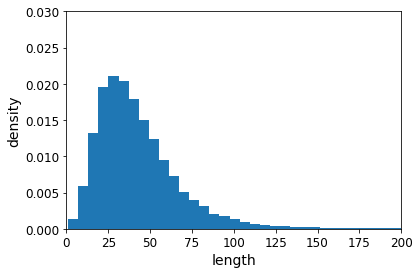

In [14]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [15]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 4889s 45ms/step - loss: 4.1345 - accuracy: 0.1617 - sparse_top_k_categorical_accuracy: 0.3621 - val_loss: 3.1818 - val_accuracy: 0.2883 - val_sparse_top_k_categorical_accuracy: 0.5731
Epoch 2/2
107813/107813 [==============================] - 4304s 40ms/step - loss: 2.7349 - accuracy: 0.3736 - sparse_top_k_categorical_accuracy: 0.6636 - val_loss: 2.4613 - val_accuracy: 0.4247 - val_sparse_top_k_categorical_accuracy: 0.7146


In [17]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [18]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.59883034

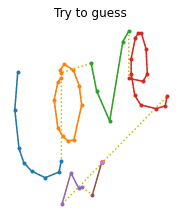

Top-5 predictions:
  1. animal migration 44.633%
  2. rain 8.480%
  3. stethoscope 5.937%
  4. eyeglasses 4.367%
  5. ant 3.603%
Answer: squiggle


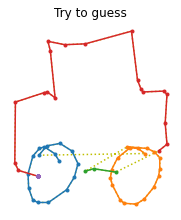

Top-5 predictions:
  1. tractor 27.315%
  2. motorbike 22.947%
  3. eyeglasses 8.759%
  4. police car 7.104%
  5. bicycle 5.333%
Answer: tractor


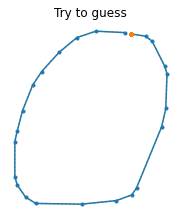

Top-5 predictions:
  1. hexagon 11.994%
  2. circle 11.602%
  3. onion 10.256%
  4. potato 7.140%
  5. octagon 5.472%
Answer: circle


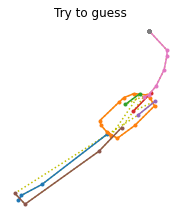

Top-5 predictions:
  1. see saw 14.388%
  2. toothbrush 11.143%
  3. beach 9.329%
  4. fork 8.881%
  5. feather 6.893%
Answer: paintbrush


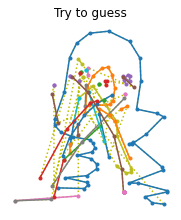

Top-5 predictions:
  1. hedgehog 7.224%
  2. spider 6.192%
  3. the mona lisa 5.401%
  4. snowflake 3.897%
  5. lion 3.852%
Answer: frog


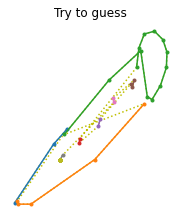

Top-5 predictions:
  1. beach 37.835%
  2. rake 4.634%
  3. syringe 4.634%
  4. snake 4.371%
  5. line 3.389%
Answer: clarinet


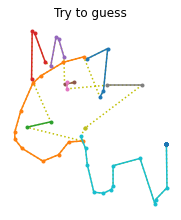

Top-5 predictions:
  1. animal migration 16.332%
  2. scorpion 14.464%
  3. rhinoceros 5.076%
  4. bird 4.620%
  5. submarine 3.633%
Answer: rhinoceros


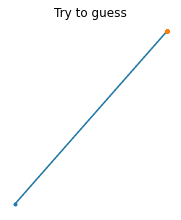

Top-5 predictions:
  1. line 55.908%
  2. broom 2.796%
  3. ant 2.452%
  4. stitches 1.705%
  5. squiggle 1.598%
Answer: squiggle


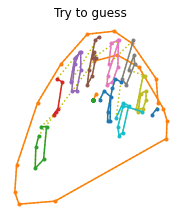

Top-5 predictions:
  1. peas 10.197%
  2. stitches 7.303%
  3. toe 7.284%
  4. rain 5.235%
  5. the great wall of china 4.262%
Answer: cookie


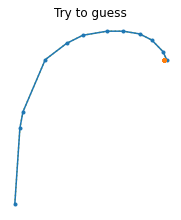

Top-5 predictions:
  1. streetlight 24.121%
  2. garden hose 7.125%
  3. finger 5.827%
  4. feather 5.385%
  5. spoon 5.380%
Answer: streetlight


In [19]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [20]:
model.save("my_sketchrnn")

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets
